# Explore predictor variables for floor height

Explore correlation between exisiting floor height data and DEM and other building attributes

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
# Use only points matched to footprint
df_footprint = gpd.read_file('launceston_FFH_footprint_geometry_dem_deriv.geojson')

## Visual correlations

In [9]:
df_footprint['FFH_1m'] = df_footprint['LCC_FLOOR'] - df_footprint['min_dem_1m']

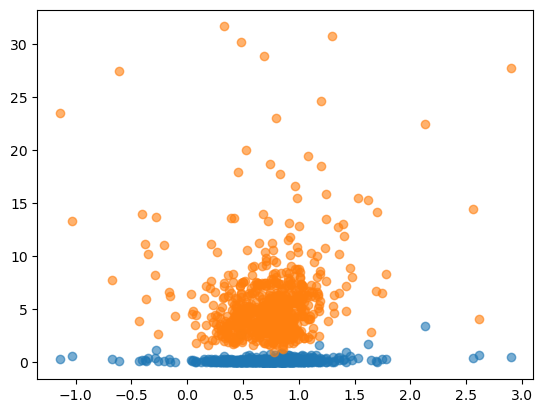

In [10]:
plt.scatter(df_footprint['FFH_1m'], df_footprint['min_slope'], alpha=0.6)
plt.scatter(df_footprint['FFH_1m'], df_footprint['max_slope'], alpha=0.6)

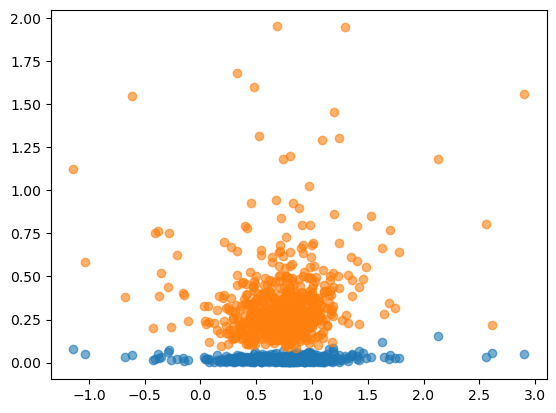

In [11]:

plt.scatter(df_footprint['FFH_1m'], df_footprint['min_tri'], alpha=0.6)
plt.scatter(df_footprint['FFH_1m'], df_footprint['max_tri'], alpha=0.6)

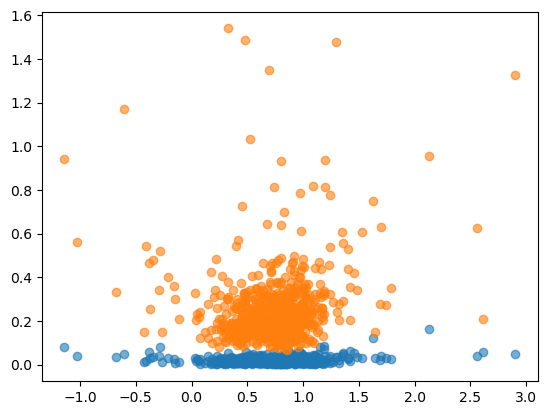

In [12]:

plt.scatter(df_footprint['FFH_1m'], df_footprint['min_rough'], alpha=0.6)
plt.scatter(df_footprint['FFH_1m'], df_footprint['max_rough'], alpha=0.6)

### Clean up categorical fields 

make all lower case; take first letter to combine y/yes, n/no etc

In [13]:
cate_cols = df_footprint.select_dtypes(exclude=[float, int]).columns[:-1]
print(cate_cols)
for col in cate_cols:
    df_footprint[col] = df_footprint[col].str.lower()

Index(['ZONE', 'LID', 'ADDRESS', 'SUBURB', 'POSTCODE', 'FEATURE_NA',
       'NEXIS_CAD_', 'SETTLEMENT', 'LOCAL_USE', 'NEXIS_USE_', 'NEXIS_USE1',
       'Survey_COM', 'Survey_G_1', 'Survey_Par', 'Survey_C_1', 'Survey_Gab',
       'NEXIS_CONS', 'USE', 'NEXIS_YEAR', 'LOCAL_ROOF', 'NEXIS_ROOF',
       'Survey_Roo', 'LOCAL_WALL', 'NEXIS_WALL', 'Survey_Wal', 'Survey_C_2',
       'Survey_Ind', 'NEXIS_NO_1', 'RENAISSA0', 'RENAISSA1', 'LCC_TYPE'],
      dtype='object')


In [14]:
df_footprint['Survey_C_1'] = df_footprint['Survey_C_1'].str[0:1]
df_footprint['Survey_Par'] = df_footprint['Survey_Par'].str[0:1]
df_footprint['Survey_Gab'] = df_footprint['Survey_Gab'].str[0:1]

In [15]:
df_footprint['LCC_TYPE'].unique()

array(['hse', 'hsebk', 'hsewb', 'house', 'bldwbhall', 'bldgi', 'res',
       'bldbk', None, 'bld', 'garage', 'gar', 'hseren', 'hsebkbrd',
       'hsewbbk', 'bldwb', 'bldal', 'bldfib', 'building', 'shd', 'notype',
       'hsesto', 'bldwbchu'], dtype=object)

## Explore regression model using different features


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

Explained Variance (R^2): 0.4406
[0.43314846 0.04195257 0.11043311 0.13283764 0.23827866]
Cross-Validation Accuracy (R^2): 0.1913
RMSE: 0.20306542131296162
['range_dem_1m' 'min_dem_1m' 'LOCAL_YEAR' 'max_dem_1m' 'Survey_G_1_rtf'
 'NEXIS_YEAR_1914 - 1946' 'NEXIS_WALL_timber' 'NEXIS_WALL_fibre cement'
 'NEXIS_WALL_cavity and solid masonry' 'NEXIS_WALL_veneer masonry'] [0.3151292  0.20462312 0.18460089 0.12463873 0.0762151  0.00981845
 0.00764912 0.0073051  0.0072635  0.00713987]


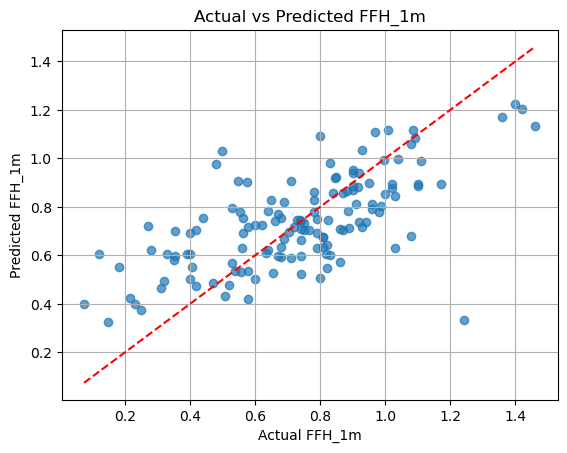

In [28]:

ffh_col = 'FFH_1m'
#df_r = df_footprint[df_footprint[ffh_col]>0]
df_r = df_r[(df_r[ffh_col]>=0) & (df_r[ffh_col]<2)]


cat_features = ['Survey_G_1', 'NEXIS_ROOF', 'NEXIS_WALL', 'NEXIS_YEAR'] #LCC_TYPE', 'Survey_C_1', 'Survey_Roo', 'Survey_Wal']
num_features = ['min_dem_1m', 'range_dem_1m', 'LOCAL_YEAR', 'max_dem_1m', 
                #'min_slope', 'max_slope', 'mean_slope', 
                #'min_tri', 
                #'max_tri', 'mean_tri',
                #'min_tpi', 
                #'max_tpi', 'mean_tpi',
                #'min_rough', 
                #'max_rough', 'mean_rough'
                ]#, 'max_dem_1m', 'Survey_Grd', 'Survey_Chi', 'NEXIS_FOOT', 'NEXIS_FLOO']

# Prepare the features and target variable
X = df_r[cat_features+num_features]
y = df_r[ffh_col]

# One-hot encode categorical variables
encoder = OneHotEncoder()#sparse=False)
X_encoded_categorical = encoder.fit_transform(X[cat_features]).toarray()

# Normalize numeric features
scaler = StandardScaler()
X_normalized_numeric = scaler.fit_transform(X[num_features])

# Concatenate the encoded categorical features with the normalized numeric features
X_encoded = np.hstack((X_encoded_categorical, X_normalized_numeric))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate explained variance
explained_variance = r2_score(y_test, y_pred)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Perform cross-validation
cv_scores = cross_val_score(model, X_encoded, y, cv=5)  # 5-fold cross-validation
print(cv_scores)
mean_cv_score = np.mean(cv_scores)
print(f"Cross-Validation Accuracy (R^2): {mean_cv_score:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {ffh_col}')
plt.xlabel(f'Actual {ffh_col}')
plt.ylabel(f'Predicted {ffh_col}')
plt.grid(True)

# Assuming 'model' is your trained RandomForestRegressor and X_encoded contains feature names
importances = model.feature_importances_
# Get the feature names (assuming you have them stored somewhere)
feature_names = np.array(encoder.get_feature_names_out())
all_feature_names = np.concatenate((feature_names, num_features))
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

print(all_feature_names[indices][:10], importances[indices][:10])

Explained Variance (R^2): 0.9146
RMSE: 0.07887360788042164


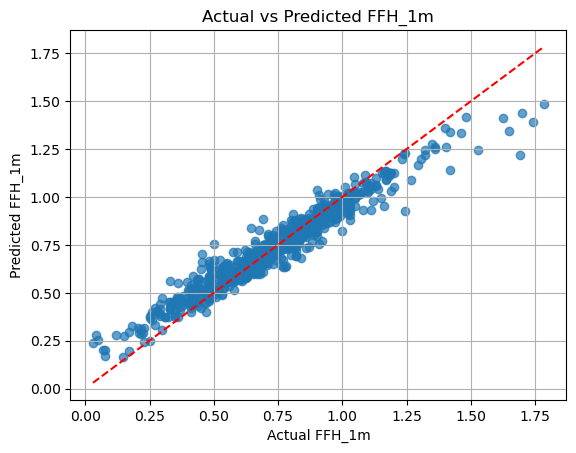

In [29]:
# Fit the best model on all data points
model.fit(X_encoded, y)


# Get predictions for all data points
predictions = model.predict(X_encoded)

# Calculate explained variance
explained_variance = r2_score(y, predictions)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"RMSE: {rmse}")

plt.scatter(y, predictions, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {ffh_col}')
plt.xlabel(f'Actual {ffh_col}')
plt.ylabel(f'Predicted {ffh_col}')
plt.grid(True)

## Above model is likely overfit 